# Khởi tạo tham số và các hàm cần thiết

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import pandas as pd
import matplotlib
import matplotlib.gridspec as gridspec
plt.style.use('ggplot')
# import seaborn as sns
from PIL import Image
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots

## Các hàm mục tiêu

In [2]:
def Rastrigin(particle):
    A = 10
    d = particle.shape[0]
    return A*d + sum([particle[i]**2 - A*math.cos(2*math.pi*particle[i]) for i in range(d)])

def Rosenbrock(particle):
    return sum([100*(particle[i+1] - particle[i]**2)**2 + (1 - particle[i])**2 for i in range(particle.shape[0]-1)])

def Eggholder(particle):
    x = particle[0]
    y = particle[1]
    return -(y + 47)*math.sin(math.sqrt(abs(x/2 + y + 47))) - x*math.sin(math.sqrt(abs(x - y - 47)))

def Ackley(particle):
    x = particle[0]
    y = particle[1]
    return -20*math.exp(-0.2*math.sqrt(0.5*(x**2 + y**2))) - math.exp(0.5*(math.cos(2*math.pi*x) + math.cos(2*math.pi*y))) + math.e + 20



##  Tham số mặc định

In [53]:
# Thiết lập một số tham số khởi tạo
# quán tính
w = 0.7298

#Hằng số gia tốc
c1 = c2 = 1.49618

# Random seed
RANDOM_SEED = 17521056

# mapping 
mapping = {
    Rastrigin: (-5.12,5.12),
    Rosenbrock: (-1000 , 1000),
    Eggholder: (-512,512),
    Ackley: (-5,5)
}

## Hàm visualize

In [63]:
def draw(results, search_domain, func):
    # Hàm animation
    def animate(i):
        plt.title("Population {}".format(i))
        x = results[i][:,0]
        y = results[i][:,1]
        points.set_data(x, y)
        return points,
        
    fig = plt.figure()
    ax = plt.axes(xlim = search_domain, ylim=search_domain)
    points, = ax.plot([], [], 'o', color = 'red')
    
    # Lấy các giá trị X,Y,Z
    X = []
    Y = []
    Z_grid = []
    
    for i in range(len(results)):
        X.append(results[i][:,0])
        Y.append(results[i][:,1])
    
    # tăng số lượng mẫu
    X_grid, Y_grid = np.meshgrid(X,Y)
    X_grid = X_grid.flatten()
    Y_grid = Y_grid.flatten()
    
    # Tìm giá trị của Z_grid
    for x, y in zip(X_grid, Y_grid):
        temp = np.array([x,y])
        Z_grid.append(func(temp))
    
    # Chuyển Z_grid về array
    Z_grid = np.array(Z_grid)
    
    # Vẽ countour 
    plt.tricontour(X_grid, Y_grid, Z_grid)
    # plt.tripcolor(X_grid, Y_grid, Z_grid)
    # Vẽ amination
    anim = FuncAnimation(fig, animate, frames=len(results), interval=400, blit=True)
    # save .gif
    anim.save("{}_{}.gif".format(results[0].shape[1],func))
    # Hiển thị kq
    return anim
    

## Hàm khởi tạo ban đầu

In [55]:
def init(num_values, search_domain, N = 32, random_seed = RANDOM_SEED):
    np.random.seed(random_seed)
    return np.random.uniform(search_domain[0],search_domain[1],(N,num_values))

# Ring PSO

In [91]:
def ringPSO(num_values, function, search_domain, N = 32, random_seed = RANDOM_SEED, G = 50):
    count = 0
    particles = init(num_values, search_domain, N, random_seed)
    results = [particles.copy()]
    # vị trí tốt nhất mà phần tử đó đã đạt được trong quá khứ
    pBest = [None]*N
    yBest = np.zeros((N,num_values))
    
    # vị trí tốt nhất mà cả cụm đạt được trong quá khứ
    gBest = [1e+10000]*N
    zBest = [None]*N
    
    # Khởi tạo vị trí trong lần lặp đầu tiên
    for i in range(N):
        count += 1
        pBest[i] = function(particles[i])
        yBest[i] = particles[i]
    
    # Tìm vị trí tôt nhất trong K phần tử lân cận
    for i in range(N - 1):
        
        # Tìm giá trị nhỏ nhất trong k phần tử
        local_min = min(pBest[i-1],pBest[i],pBest[i+1])
        
        if gBest[i] > local_min:
        
            # Lưu lại giá trị nhỏ nhất
            gBest[i] = local_min

            # Lưu lại vị trí tốt nhất
            min_id = np.argmin([pBest[i-1],pBest[i],pBest[i+1]]) - 1
            zBest[i] = yBest[i + min_id]
                
    # Phần tử cuối của mảng
    local_min = min(pBest[N-2],pBest[N-1],pBest[0])
    if gBest[-1] > local_min:
        gBest[-1] = local_min
        
        # Lấy min_id
        min_id = np.argmin([pBest[N-2],pBest[N-1],pBest[0]])
        zBest[-1] = yBest[-min_id]

    # Tìm vector hiện tại tốt nhất của mỗi particle: V[i] = pos[i] - pos_bestest_k[i]
    V = particles - np.array(zBest)

    if num_values == 2:
        repeat = 1
        while(repeat <= G):
            for i in range(N):
                r1, r2 = np.random.uniform(0,1,(2, num_values))
                # cognitive component
                cogn = c1*r1*(yBest[i] - particles[i])
                # social component
                social = c2*r2*(zBest[i] - particles[i])
                # Update V[i]
                V[i] = w*V[i] + cogn + social
                # Update position
                particles[i] += V[i]

                # Check giá trị của mỗi vị trí trong search domain
                for j in range(num_values):
                    if particles[i][j] > search_domain[1]:
                        particles[i][j] = search_domain[1] - np.random.uniform(0,.01)
                    elif particles[i][j] < search_domain[0]:
                        particles[i][j] = search_domain[0] + np.random.uniform(0,.01)

            # Lặp
            for i in range(N):
                if function(particles[i]) < pBest[i]:
                    pBest[i] = function(particles[i])
                    yBest[i] = particles[i]

            # Tìm vị trí tôt nhất trong K phần tử lân cận

            for i in range(N - 1):
                # Tìm giá trị nhỏ nhất trong k phần tử
                local_min = min(pBest[i-1],pBest[i],pBest[i+1])
                if gBest[i] > local_min:
                    # Lưu lại giá trị nhỏ nhất
                    gBest[i] = local_min

                    # Lưu lại vị trí tốt nhất
                    min_id = np.argmin([pBest[i-1],pBest[i],pBest[i+1]]) - 1
                    zBest[i] = yBest[i + min_id]

            # Phần tử cuối của mảng
            local_min = min(pBest[N-2],pBest[N-1],pBest[0])
            if gBest[-1] > local_min:
                gBest[-1] = local_min

                # Lấy min_id
                min_id = np.argmin([pBest[N-2],pBest[N-1],pBest[0]])
                zBest[-1] = yBest[-min_id]
            repeat+=1
            results.append(particles.copy())
    else:
        while(count != 1000000):
            for i in range(N):
                r1, r2 = np.random.uniform(0,1,(2, num_values))
                # cognitive component
                cogn = c1*r1*(yBest[i] - particles[i])
                # social component
                social = c2*r2*(zBest[i] - particles[i])
                # Update V[i]
                V[i] = w*V[i] + cogn + social
                # Update position
                particles[i] += V[i]

                # Check giá trị của mỗi vị trí trong search domain
                for j in range(num_values):
                    if particles[i][j] > search_domain[1]:
                        particles[i][j] = search_domain[1] - np.random.uniform(0,.01)
                    elif particles[i][j] < search_domain[0]:
                        particles[i][j] = search_domain[0] + np.random.uniform(0,.01)

            # Lặp
            for i in range(N):
                if count == 1000000:
                    break
                count += 1
                if function(particles[i]) < pBest[i]:
                    pBest[i] = function(particles[i])
                    yBest[i] = particles[i]

            # Tìm vị trí tôt nhất trong K phần tử lân cận

            for i in range(N - 1):
                # Tìm giá trị nhỏ nhất trong k phần tử
                local_min = min(pBest[i-1],pBest[i],pBest[i+1])
                if gBest[i] > local_min:

                    # Lưu lại giá trị nhỏ nhất
                    gBest[i] = local_min

                    # Lưu lại vị trí tốt nhất
                    min_id = np.argmin([pBest[i-1],pBest[i],pBest[i+1]]) - 1
                    zBest[i] = yBest[i + min_id]

            # Phần tử cuối của mảng
            local_min = min(pBest[N-2],pBest[N-1],pBest[0])
            if gBest[-1] > local_min:
                gBest[-1] = local_min

                # Lấy min_id
                min_id = np.argmin([pBest[N-2],pBest[N-1],pBest[0]])
                zBest[-1] = yBest[-min_id]
            results.append(particles.copy())
    index = np.argmin(gBest)
    return results, gBest[index], zBest[index]

### TH1:  d = 2

### với hàm mục tiêu là Rastrigin

Lời giải tốt nhất:  0.005130085227268211
Điểm cho lời giải tốt nhất là: [0.00295636 0.00413756]


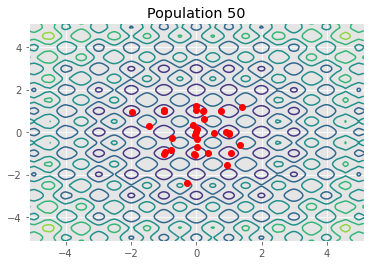

In [93]:
f = open("results_d2.txt",'a')
results = ringPSO(2,Rastrigin,mapping[Rastrigin])
print("Lời giải tốt nhất: ", results[1])
print("Điểm cho lời giải tốt nhất là:", results[2])
f.write("Rastrigin\n")
f.write("Best find: {}, Best position: {}\n".format(results[1], results[2]))

# visulize khi G = 50
points = results[0]
ani = draw(points,mapping[Rastrigin],Rastrigin)

### với hàm mục tiêu là Rosenbrock

Lời giải tốt nhất:  0.7009525530189266
Điểm cho lời giải tốt nhất là: [1.00466169 0.9256235 ]


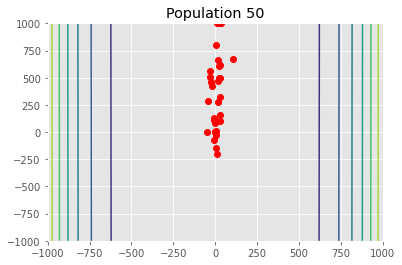

In [94]:
f = open("results_d2.txt",'a')
results = ringPSO(2,Rosenbrock,mapping[Rosenbrock])
print("Lời giải tốt nhất: ", results[1])
print("Điểm cho lời giải tốt nhất là:", results[2])
f.write("Rosenbrock\n")
f.write("Best find: {}, Best position: {}\n".format(results[1], results[2]))

# visulize khi G = 50
points = results[0]
ani = draw(points,mapping[Rosenbrock],Rosenbrock)

### Hàm mục tiêu là Eggholder

Lời giải tốt nhất:  -959.6262066107308
Điểm cho lời giải tốt nhất là: [511.99573329 404.22534866]


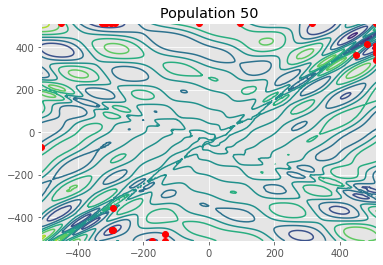

In [95]:
f = open("results_d2.txt",'a')
results = ringPSO(2,Eggholder,mapping[Eggholder])
print("Lời giải tốt nhất: ", results[1])
print("Điểm cho lời giải tốt nhất là:", results[2])
f.write("Eggholder\n")
f.write("Best find: {}, Best position: {}\n".format(results[1], results[2]))

# visulize khi G = 50
points = results[0]
ani = draw(points,mapping[Eggholder],Eggholder)

### Hàm mục tiêu là Ackley

Lời giải tốt nhất:  0.00313083883577292
Điểm cho lời giải tốt nhất là: [ 0.00083856 -0.00070512]


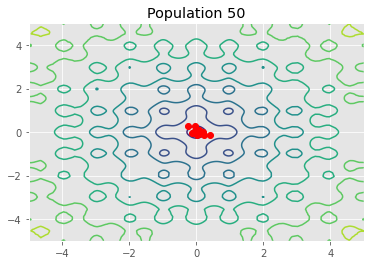

In [96]:
f = open("results_d2.txt",'a')
results = ringPSO(2,Ackley,mapping[Ackley])
print("Lời giải tốt nhất: ", results[1])
print("Điểm cho lời giải tốt nhất là:", results[2])
f.write("Ackley\n")
f.write("Best find: {}, Best position: {}\n".format(results[1], results[2]))
# visulize khi G = 50
points = results[0]
ani = draw(points,mapping[Ackley],Ackley)

## TH d = 10

### Hàm mục tiêu là  Rastrigin

In [97]:
f = open("d10_ring.txt",'a')
f.write("Rastrigin\n")
l = [128, 256, 512, 1024, 2048]
mean_objective_value = []
std = []
for N in l:
    f.write("N = {}\n".format(N))
    results = []
    for i in range(10):
        pred = ringPSO(10,Rastrigin, mapping[Rastrigin],N,RANDOM_SEED + i)
        f.write("i = {}, random_seed = {}, Giá trị tốt nhất = {}, vị trí tốt nhất = {}\n".format(i,RANDOM_SEED+i,pred[1],pred[2]))
        results.append(pred[1])
    # Tính độ lệch chuẩn:
    std.append(np.std(results))
    mean_objective_value.append(sum(results)/10)
    f.write("mean_objective_value = {}, std = {}\n".format(sum(results)/10,np.std(results)))


### Hàm mục tiêu là Rosenbrock

In [98]:
f = open("d10_ring.txt",'a')
f.write("Rosenbrock\n")
l = [128, 256, 512, 1024, 2048]
mean_objective_value = []
std = []
for N in l:
    f.write("N = {}\n".format(N))
    results = []
    for i in range(10):
        pred = ringPSO(10,Rosenbrock, mapping[Rosenbrock],N,RANDOM_SEED + i)
        f.write("i = {}, random_seed = {}, Giá trị tốt nhất = {}, vị trí tốt nhất = {}\n".format(i,RANDOM_SEED+i,pred[1],pred[2]))
        results.append(pred[1])
    # Tính độ lệch chuẩn:
    std.append(np.std(results))
    mean_objective_value.append(sum(results)/10)
    f.write("mean_objective_value = {}, std = {}\n".format(sum(results)/10,np.std(results)))


In [100]:
print(mean_objective_value)
print(std)

[0.005975057566464717, 0.06426508731696477, 0.11334676442622756, 0.05160562415601786, 0.4708461203203852]
[0.002836956690784187, 0.09075442012040699, 0.16505870126279343, 0.05859471168123321, 0.5018530420942128]


# Star PSO

In [79]:
def starPSO(num_values, function, search_domain, N = 32, random_seed = RANDOM_SEED, G = 50):
    particles = init(num_values, search_domain, N, random_seed)
    results = [particles.copy()]
    # vị trí tốt nhất mà phần tử đó đã đạt được trong quá khứ
    pBest = [1e+100]*N
    yBest = np.zeros((N,num_values))

    # vị trí tốt nhất mà cả bầy đàn đã đạt được trong quá khứ
    gBest = 1e+100
    zBest = None

    # Khởi Tìm vị trí tốt nhất trong lần lặp đầu tiên
    count = 0
    for i, particle in enumerate(particles):
        count += 1
        if function(particle) < pBest[i]:
            pBest[i] = function(particle)
            yBest[i] = particle
            if pBest[i] < gBest:
                gBest = pBest[i]
                zBest = yBest[i]
    # Find the current velocity vector of particle i
    V = particles - zBest
    repeat = 1
    if num_values == 2:
        while(repeat <=50):
            for i in range(N):
                # random r1, r2
                r1, r2 = np.random.uniform(0, 1,(2, num_values))
                # cognitive component
                cogn = c1*r1*(yBest[i] - particles[i])
                # social component
                social = c2*r2*(zBest - particles[i])

                # update V[i]
                V[i] = w*V[i] + cogn + social
                # Update position
                particles[i] += V[i]
                for j in range(num_values):
                    if particles[i][j] > search_domain[1]:
                        particles[i][j] = search_domain[1] - np.random.uniform(0,0.01)

                    if particles[i][j] < search_domain[0]:
                        particles[i][j] = search_domain[0] + np.random.uniform(0,0.01)

            for i in range(N):
                if function(particles[i]) < pBest[i]:
                    pBest[i] = function(particles[i])
                    yBest[i] = particles[i]
                    if pBest[i] < gBest:
                        gBest = pBest[i]
                        zBest = yBest[i]
            repeat += 1
            temp = particles.copy()
            results.append(temp)
    else:
        while(count != 1000000):
            for i in range(N):
                # random r1, r2
                r1, r2 = np.random.uniform(0, 1,(2, num_values))
                # cognitive component
                cogn = c1*r1*(yBest[i] - particles[i])
                # social component
                social = c2*r2*(zBest - particles[i])

                # update V[i]
                V[i] = w*V[i] + cogn + social
                # Update position
                particles[i] += V[i]
                for j in range(num_values):
                    if particles[i][j] > search_domain[1]:
                        particles[i][j] = search_domain[1] - np.random.uniform(0,0.01)

                    if particles[i][j] < search_domain[0]:
                        particles[i][j] = search_domain[0] + np.random.uniform(0,0.01)

            for i in range(N):
                if count == 1000000:
                    break
                count += 1
                if function(particles[i]) < pBest[i]:
                    pBest[i] = function(particles[i])
                    yBest[i] = particles[i]
                    if pBest[i] < gBest:
                        gBest = pBest[i]
                        zBest = yBest[i]
            temp = particles.copy()
            results.append(temp)
                
    return results , gBest, zBest

## d = 2

 ### Rastrigin

Lời giải tốt nhất:  3.0702509192792604e-06
Điểm cho lời giải tốt nhất là: [-7.26920460e-05  1.00953153e-04]


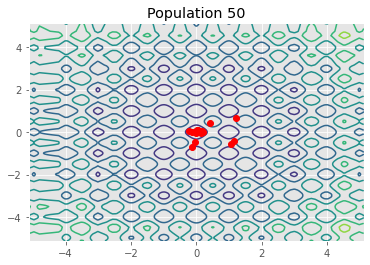

In [87]:
f = open("results_d2_star.txt",'a')
results = starPSO(2,Rastrigin,mapping[Rastrigin])
print("Lời giải tốt nhất: ", results[1])
print("Điểm cho lời giải tốt nhất là:", results[2])
f.write("Rastrigin\n")
f.write("Best find: {}, Best position: {}\n".format(results[1], results[2]))
# visulize 
points = results[0]
ani = draw(points,mapping[Rastrigin],Rastrigin)

### Rosenbrock

Lời giải tốt nhất:  0.4497697239235599
Điểm cho lời giải tốt nhất là: [0.98841147 0.90990238]


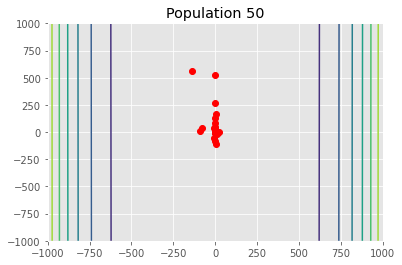

In [88]:
results = starPSO(2,Rosenbrock,mapping[Rosenbrock])
print("Lời giải tốt nhất: ", results[1])
print("Điểm cho lời giải tốt nhất là:", results[2])
f.write("Rosenbrock\n")
f.write("Best find: {}, Best position: {}\n".format(results[1], results[2]))
# visulize 
points = results[0]
ani = draw(points,mapping[Rosenbrock],Rosenbrock)

### Eggholder

Lời giải tốt nhất:  -959.6399424083683
Điểm cho lời giải tốt nhất là: [511.99983097 404.22024113]


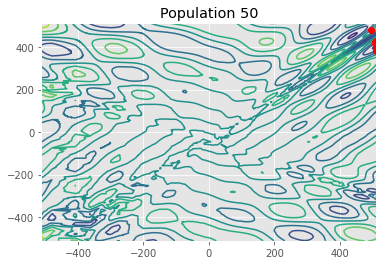

In [89]:
results = starPSO(2,Eggholder,mapping[Eggholder])
print("Lời giải tốt nhất: ", results[1])
print("Điểm cho lời giải tốt nhất là:", results[2])
f.write("Rosenbrock\n")
f.write("Best find: {}, Best position: {}\n".format(results[1], results[2]))
# visulize 
points = results[0]
ani = draw(points,mapping[Eggholder],Eggholder)

### Ackley

Lời giải tốt nhất:  0.00041825212197821315
Điểm cho lời giải tốt nhất là: [-1.26571513e-05  1.47125720e-04]


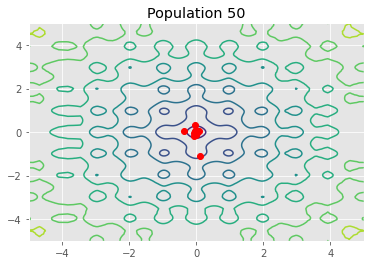

In [90]:
results = starPSO(2,Ackley,mapping[Ackley])
print("Lời giải tốt nhất: ", results[1])
print("Điểm cho lời giải tốt nhất là:", results[2])
f.write("Ackley\n")
f.write("Best find: {}, Best position: {}\n".format(results[1], results[2]))
# visulize 
points = results[0]
ani = draw(points,mapping[Ackley],Ackley)

## d = 10

### Rastrigin

In [106]:
f = open("d10_star.txt",'a')
f.write("Rastrigin\n")
l = [128, 256, 512, 1024, 2048]
mean_objective_value = []
std = []
for N in l:
    f.write("N = {}\n".format(N))
    results = []
    for i in range(10):
        pred = starPSO(10,Rastrigin, mapping[Rastrigin],N,RANDOM_SEED + i)
        f.write("i = {}, random_seed = {}, Giá trị tốt nhất = {}, vị trí tốt nhất = {}\n".format(i,RANDOM_SEED+i,pred[1],pred[2]))
        results.append(pred[1])
    # Tính độ lệch chuẩn:
    std.append(np.std(results))
    mean_objective_value.append(sum(results)/10)
    f.write("mean_objective_value = {}, std = {}\n".format(sum(results)/10,np.std(results)))
print("mean: {}, std: {}".format(mean_objective_value, std))

mean: [1.9899181141865854, 0.9949590570932955, 0.39798362283731875, 0.29848771712798766, 7.977973837114405e-12], std: [1.4757627707874774, 1.0899230387281371, 0.4874284009678506, 0.6370846453727386, 2.340819321864123e-11]


### Rosenbrock

In [107]:
f = open("d10_star.txt",'a')
f.write("Rosenbrock\n")
l = [128, 256, 512, 1024, 2048]
mean_objective_value = []
std = []
for N in l:
    f.write("N = {}\n".format(N))
    results = []
    for i in range(10):
        pred = starPSO(10,Rosenbrock, mapping[Rosenbrock],N,RANDOM_SEED + i)
        f.write("i = {}, random_seed = {}, Giá trị tốt nhất = {}, vị trí tốt nhất = {}\n".format(i,RANDOM_SEED+i,pred[1],pred[2]))
        results.append(pred[1])
    # Tính độ lệch chuẩn:
    std.append(np.std(results))
    mean_objective_value.append(sum(results)/10)
    f.write("mean_objective_value = {}, std = {}\n".format(sum(results)/10,np.std(results)))
print("mean: {}, std: {}".format(mean_objective_value, std))


mean: [6.654048693452374, 10.137740023509263, 30.759113421489253, 2.9691355759671856, 136.98125597002397], std: [13.175998641336589, 30.385008759994562, 87.51907376879855, 3.4247732961111064, 218.87690626654367]
